In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from math import *
from numpy import linalg as LA
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from DiTree import *

UNDIRECTED STOCHASTIC CASE (alg 2):
- to generate data, treat b_i as a random variable (see paper), sample from dataset U(1,10) (uniform 1-10)
- also change plots: need expectation
- expectation of b_i = 5.5, for plots can use a deterministic function with 5.5 replaced everywhere

- run each for 10 samplepaths (tweak as needed for good plots) --- plot with confidence intervals
p 2 different settings for graph: petersen (10 nodes) and random (100 nodes)

In [2]:
# UNDIRECTED STOCHASTIC ALGORITHM
# --------------------------------

In [3]:
# Setting up data
# ---------------

# 10 x 11
"""
returns a tuple (mean, margin of error)
"""
def calculate_mean_and_moe(data, t=1.833):
    mean = np.mean(data, axis=0) # calculate mean along rows of data
    stdev = np.std(data, axis=0)
    moe = t * stdev / sqrt(data.shape[0])
    return mean, moe

np.random.seed(1)
moreau = 0.1
N = 100

"""
returns:
a_values (vector size N)
C matrix (matrix size NxN)
upper box constraints (vector size N)
lower box constraints (vector size N)
"""

# b_i is constantly sampled ~U[1,10] for all i = 0..(n-1)
def sample_b():
    return np.random.uniform(low=1, high=1000, size=N)

# C is a positive definite matrix
A = np.random.randn(N, N//2)
C = A.dot(A.T)                           # C_bar in the paper
a_values = np.diag(C)
reg_weight = 1e-5 + np.max([0, -np.min(LA.eigvals(C - 0.5 * np.diagflat(a_values)))])
print(min(LA.eigvals(C)))
print(a_values)
print(reg_weight)

# lower box constraint cannot exceed the upper box constraint
upper_box_constraints = np.random.uniform(low=50, high=100, size=N)
lower_box_constraints = np.zeros((N))

(-3.311174875848273e-14+0j)
[47.03771925 31.67946123 38.34164291 50.85441547 60.14430185 40.85508468
 60.55563706 52.78297267 61.4558614  46.19609781 48.07077298 62.21415364
 43.11845527 49.50555811 56.20623303 50.30324446 38.17452082 48.41463614
 41.69508851 36.26966179 62.75254067 48.93987307 46.7723237  42.99823093
 48.73067003 41.16645365 41.18468346 60.67031824 56.76095474 75.34861298
 51.1354176  57.99039334 59.64052152 71.84008246 62.90734037 48.61202339
 42.30670083 42.71685863 46.95961774 52.29016602 47.95963965 39.29885529
 49.63268465 40.88775892 49.83330811 60.47107302 57.66421752 53.55651098
 46.03524984 51.5905046  42.27202413 57.91924367 40.30933437 46.4802052
 50.93031669 44.91411737 51.22770972 36.93262417 32.1633887  44.46418556
 53.23854465 50.00167571 48.53572171 42.17238256 63.093845   58.26899997
 54.5876695  50.61129838 59.48929848 44.96090258 59.61212831 44.01622213
 44.33858788 41.85253269 44.77513539 38.39487986 44.77102039 61.0681948
 69.95431138 43.8345203  

In [5]:
# CHANGE THIS FOR EACH PLOT STYLE
print(N)
print(path)
path = "new_Alg2_Petersen_Graph" if N == 10 else "new_Alg2_Random_Graph"
graph_prefix = "petersen" if N == 10 else "random"

save_plots = True

100
new_Alg2_Random_Graph


In [6]:
data = {
    'a_values':a_values,
    'C_values':C,
    'upper_box_constraints':upper_box_constraints,
    'lower_box_constraints':lower_box_constraints,
    'b_sampling_procedure':sample_b
}

np.savez(f'alg2_{graph_prefix}_problem', **data)
npzfile = np.load(f'alg2_{graph_prefix}_problem.npz', allow_pickle=True)
lst = npzfile.files

In [7]:
# Graph generation
# ----------------

def petersen_graph():
    G = nx.petersen_graph()
    beta = 0.6
    W = np.diagflat(np.ones(10) * beta)
    for i in G:
        for j in G.neighbors(i):
            W[i,j] = (1-beta)/3
    return G, W

def max_degree_weights(L: np.ndarray, **kwargs):
    m, m = L.shape
    alpha = 0.5 / np.max(L)
    W = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            if i == j:
                d_i = L[i,j]
                W[i,j] = 1 - (d_i * alpha)
            elif L[i,j] != 0:
                W[i,j] = alpha
    return W

def random_graph(v, num_e):
    e = np.clip(num_e, v-1, v*(v-1)//2)
    seed = 42
    rng = np.random.default_rng(seed)
    G = nx.random_tree(v, seed=seed)
    i = v-1
    while i < e:
        v_a, v_b = tuple(rng.integers(v, size=2))
        if not G.has_edge(v_a, v_b) and v_a != v_b:
            G.add_edge(v_a, v_b)
            i += 1
    L = nx.laplacian_matrix(G).todense()
    print(L)
    W = max_degree_weights(L)
    print(W)
    return G, W

In [8]:
# Mappings and Gradient definitions
# ---------------------------------

"""
input: x is a vector size N
output: returns vector size N
"""
def grad_f_i(x, i, b_values):
    x_i = x[i]
    grad_f_i = C[i]*x_i
    grad_f_i[i] = a_values[i]*x_i + b_values[i] \
                    + (np.dot(C[i], x) - C[i,i]*x_i) \
                    + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return grad_f_i

"""
input: X_mat is a matrix NxN, X_mat[i] is the ith agent (player) vector
output: returns matrix A size N.N, where A[i] = ∇f_i(x_i) (bolded gradient f)
"""
def grad_f(X_mat, b_values):
    grad_f = np.zeros((N,N))
    for i in range(N):
        grad_f[i] = grad_f_i(X_mat[i], i, b_values)
    return grad_f + reg_weight*X_mat

"""
input: x is a vector size N
output: returns sparse vector size N, where only the ith element is nonzero
"""
def F_i(x, i, b_values):
    F_i = np.zeros(N)
    x_i = x[i]
    F_i[i] = a_values[i]*x_i + b_values[i] \
               + (np.dot(C[i], x) - C[i,i]*x_i) \
               + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return F_i

"""
input: X_mat is a matrix NxN, X_mat[i] is the ith agent (player) vector
output: returns matrix size NxN: this is the bold F in the algorithm, not the unbolded F in the problem formulation
"""
def F_fun(X_mat, b_values):
    F = np.zeros((N,N))
    for i in range(N):
        F[i] = F_i(X_mat[i], i, b_values)
    return F

In [9]:
# Deterministic (expected) mapping and gradient definitions --- for plotting/comparison purposes only
# ---------------------------------

expected_b_value = 500.5

def expected_f_fun(x):
    out = 0
    for i in range(len(x)):
        out += expected_f_i(x,i)
    return out

def expected_f_i(x, i):
    x_i = x[i]
    return 0.5*a_values[i]*x_i**2 + expected_b_value*x_i \
               + (np.dot(C[i], x) - C[i,i]*x_i)*x_i \
               + LA.norm(x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))**2 / (2*moreau) \
               + 0.5*reg_weight*LA.norm(x)**2

def expected_F_i(x, i):
    F_i = np.zeros(N)
    x_i = x[i]
    F_i[i] = a_values[i]*x_i + expected_b_value \
               + (np.dot(C[i], x) - C[i,i]*x_i) \
               + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return F_i

def expected_F_fun(X_mat):
    F = np.zeros((N,N))
    for i in range(N):
        F[i] = expected_F_i(X_mat[i], i)
    return F

def expected_F_sum(x_avg_vec):
    F_vec = np.zeros(N)
    for i in range(N):
        F_vec += expected_F_i(x_avg_vec, i)
    return F_vec

In [10]:
def DSGT(
    max_iter: int,
    epoch_size: int,
    X_0: np.ndarray,
    W: np.ndarray,
    a_update_param,
    b_update_param,
    Gamma):

    m,_ = X_0.shape
    lower_vals = np.zeros(epoch_size + 1)
    delta_x_vals = np.zeros(epoch_size + 1)
    upper_vals = np.zeros(epoch_size + 1)
    consensus_vals = np.zeros(epoch_size + 1)
    X_next = X_0

    # for data saving/pickling use
    data_X = [X_next]
    
    # update rules for stepsize (gamma_k) and regularization parameter (lambda_k)
    stepsize_rule = lambda x : 1e-3 / ((x+Gamma)**a_update_param)      # gamma_k
    regularizer_rule = lambda x : 1e-3 / ((x+Gamma)**b_update_param)    # lambda_k

    # sample the first set of b_values and perform mapping/gradient calculations
    b_values = sample_b()
    F_mat_next = F_fun(X_next, b_values)
    grad_f_mat_next = grad_f(X_next, b_values)
    
    # Y_0 is initialized to the gradient of the base function
    Y_next = F_mat_next + regularizer_rule(0) * grad_f(X_0, b_values)
    epoch_idx = 0
    
    for k in range(1, max_iter + 2):
        # updates:
        stepsize = stepsize_rule(k) * np.eye(m)
        lambda_k_now, lambda_k_next = regularizer_rule(k), regularizer_rule(k+1)
        X_now, Y_now = X_next, Y_next
        F_mat_now, grad_f_mat_now = F_mat_next, grad_f_mat_next

        # update X:
        X_next = W.dot(X_now - np.dot(stepsize, Y_now))

        # take new sample:
        b_values = sample_b()
        
        # update gradients:
        F_mat_next = F_fun(X_next, b_values)
        grad_f_mat_next = grad_f(X_next, b_values)
        
        # update Y tracker:
        Y_next = W.dot(Y_now) + (F_mat_next - F_mat_now) + (lambda_k_next * grad_f_mat_next - lambda_k_now * grad_f_mat_now)
        
        if max_iter == 0 or ((k-1) % ceil(max_iter/epoch_size)) == 0:
            data_X.append(X_next)
            
            x_ave_now = np.sum(X_now, axis=0) / m
            x_ave_next = np.sum(X_next, axis=0) / m

            lower_vals[epoch_idx] = LA.norm(expected_F_sum(x_ave_now))
            delta_x_vals[epoch_idx] = LA.norm(x_ave_next-x_ave_now)
            upper_vals[epoch_idx] = expected_f_fun(x_ave_now)
            consensus_vals[epoch_idx] = LA.norm(X_now - np.dot(np.ones((m,1)), x_ave_now.reshape(1,m)))
            epoch_idx += 1
    return lower_vals, delta_x_vals, upper_vals, consensus_vals, data_X

In [ ]:
a_b_params = [(0.5, 0.4), (0.55, 0.3), (0.6, 0.175)]
runcolor  = { (0.5, 0.4): 'r', (0.55, 0.3): 'g', (0.6, 0.175): 'b' }
runmarker = { (0.5, 0.4): 'o', (0.55, 0.3): 'v', (0.6, 0.175): 's' }

Gamma = 1

max_iter = 10_000
epoch_size = 10
num_samplepaths = 10
X_0 = (np.random.rand(N,N)) + 20 # (np.random.rand(N,N) * 10) + 100

if N == 10:
    G, W = petersen_graph()
elif N == 100:
    G, W = random_graph(N, N * np.log(N))

data_X = defaultdict(list)
lower_vals_results = {}
delta_x_vals_results = {}
upper_vals_results = {}
consensus_vals_results = {}

for (a,b) in a_b_params:
    lower_vals, delta_x_vals, upper_vals, consensus_vals = [np.zeros((num_samplepaths, epoch_size+1)) for _ in range(4)]
    for i in range(num_samplepaths):
        path_lv, path_dxv, path_uv, path_cv, data_X_sample = DSGT(max_iter, epoch_size, X_0, W, a, b, Gamma)
        data_X[(a,b)].append(data_X_sample)
        lower_vals[i] = path_lv
        delta_x_vals[i] = path_dxv
        upper_vals[i] = path_uv
        consensus_vals[i] = path_cv
    lower_vals_results[(a,b)] = calculate_mean_and_moe(lower_vals)
    delta_x_vals_results[(a,b)] = calculate_mean_and_moe(delta_x_vals)
    upper_vals_results[(a,b)] = calculate_mean_and_moe(upper_vals)
    consensus_vals_results[(a,b)] = calculate_mean_and_moe(consensus_vals)

np.savez(f'alg2_{graph_prefix}_data', data_X)

[[ 8  0  0 ... -1  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [-1  0  0 ...  8  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  7]]
[[0.76470588 0.         0.         ... 0.02941176 0.         0.        ]
 [0.         0.85294118 0.         ... 0.         0.         0.        ]
 [0.         0.         0.76470588 ... 0.         0.         0.        ]
 ...
 [0.02941176 0.         0.         ... 0.76470588 0.         0.        ]
 [0.         0.         0.         ... 0.         0.85294118 0.        ]
 [0.         0.         0.         ... 0.         0.         0.79411765]]


In [12]:
inputs = {
    'initial_x':X_0,
    'weight_matrix':W
}
outputs = {
    'lower_level_error_metric':lower_vals_results,
    'upper_level_error_metric':delta_x_vals_results,
    'consensus_error_metric':consensus_vals_results,
}
np.savez(f'alg2_{graph_prefix}_inputs', **inputs)
np.savez(f'alg2_{graph_prefix}_outputs', **outputs)

(a,b) == 
(0.5, 0.4)
(0.55, 0.3)
(0.6, 0.175)


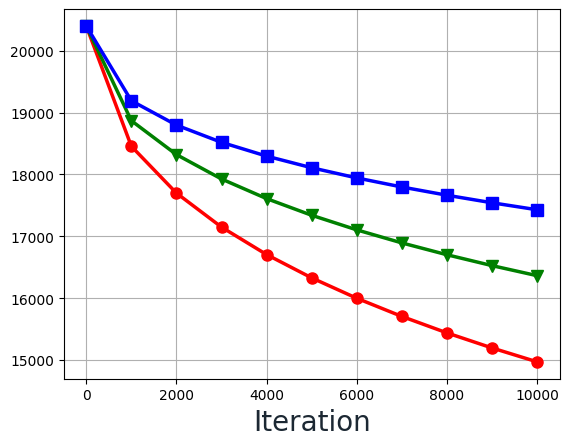

In [13]:
# LOWER LEVEL OBJECTIVE PLOTS

x_ax = list(range(0,max_iter+1,ceil(max_iter/epoch_size)))
fig0, ax0 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax0.plot(x_ax, lower_vals_results[key][0], lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax0.fill_between(x_ax, lower_vals_results[key][0] - lower_vals_results[key][1], lower_vals_results[key][0] + lower_vals_results[key][1], color=runcolor[key], alpha=0.1)
ax0.grid(True)
ax0.set_xlabel('Iteration', color='#1C2833',fontsize=20)

if save_plots:
    fig0.savefig(f"./{path}/{graph_prefix}_lower_level.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

(a,b) == 
(0.5, 0.4)
(0.55, 0.3)
(0.6, 0.175)


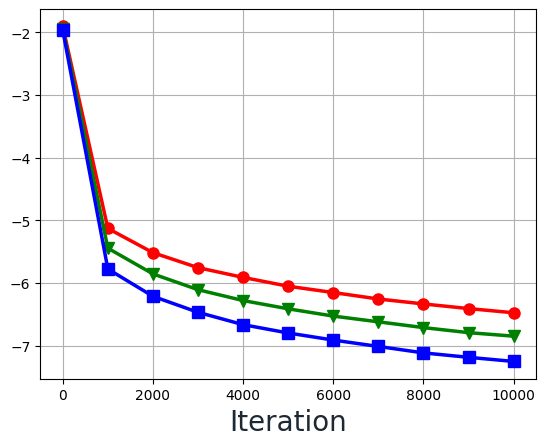

In [14]:
# CHANGE IN STEP PLOTS

fig1, ax1 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax1.plot(x_ax, np.log(delta_x_vals_results[key][0]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax1.fill_between(x_ax, np.log(delta_x_vals_results[key][0] - delta_x_vals_results[key][1]), np.log(delta_x_vals_results[key][0] + delta_x_vals_results[key][1]), color=runcolor[key], alpha=0.1)
ax1.grid(True)
ax1.set_xlabel('Iteration', color='#1C2833',fontsize=20)

if save_plots:
    fig1.savefig(f"./{path}/{graph_prefix}_upper_level.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

(a,b) == 
(0.5, 0.4)
(0.55, 0.3)
(0.6, 0.175)


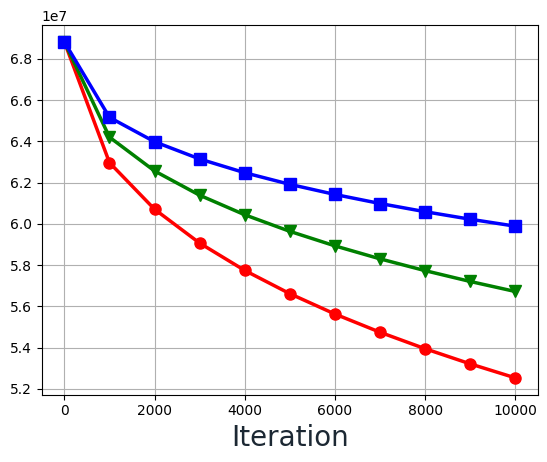

In [15]:
# UPPER LEVEL PLOTS

fig2, ax2 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax2.plot(x_ax, (upper_vals_results[key][0]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax2.fill_between(x_ax, upper_vals_results[key][0] - upper_vals_results[key][1], upper_vals_results[key][0] + upper_vals_results[key][1], color=runcolor[key], alpha=0.1)
ax2.grid(True)
ax2.set_xlabel('Iteration', color='#1C2833',fontsize=20)
    
#if save_plots:
#    fig2.savefig(f"./{path}/{graph_prefix}_upper_level.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

(a,b) == 
(0.5, 0.4)
(0.55, 0.3)
(0.6, 0.175)


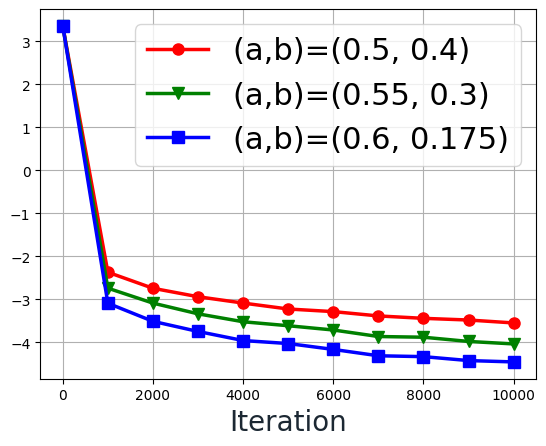

In [16]:
# CONSENSUS ERROR PLOTS

fig3, ax3 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax3.plot(x_ax, np.log(consensus_vals_results[key][0]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax1.fill_between(x_ax, np.log(consensus_vals_results[key][0] - consensus_vals_results[key][1]), np.log(consensus_vals_results[key][0] + consensus_vals_results[key][1]), color=runcolor[key], alpha=0.1)
ax3.grid(True)
ax3.set_xlabel('Iteration', color='#1C2833',fontsize=20)
ax3.legend(fontsize=22)
    
if save_plots:
    fig3.savefig(f"./{path}/{graph_prefix}_consensus_err.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

In [ ]:
descriptor = "petersen" if N == 10 else "random"
fig = plt.figure()

if N == 10:
    nx.draw_networkx(G, node_size=200, with_labels=False)
else:
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx(G, node_size=100, with_labels=False, pos=pos)
plt.show()

if save_plots:
    fig.savefig(f"./{path}/R_{descriptor}_graph_{N}_nodes.pdf", dpi=600, format="pdf")